In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re

from pytesseract import Output

In [2]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [3]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

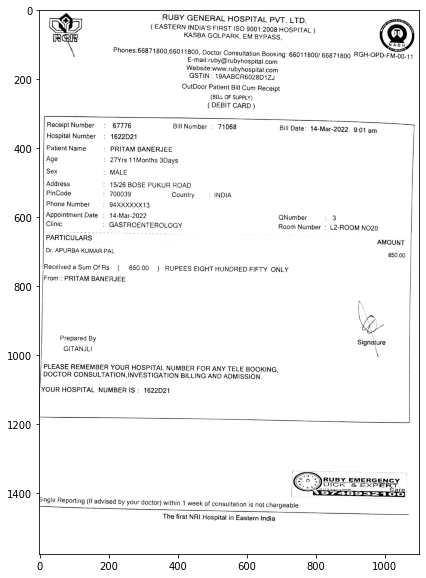

In [4]:
file_name = "S_2.png"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
plot_gray(image)

# Step 1: Text box detection

In [5]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

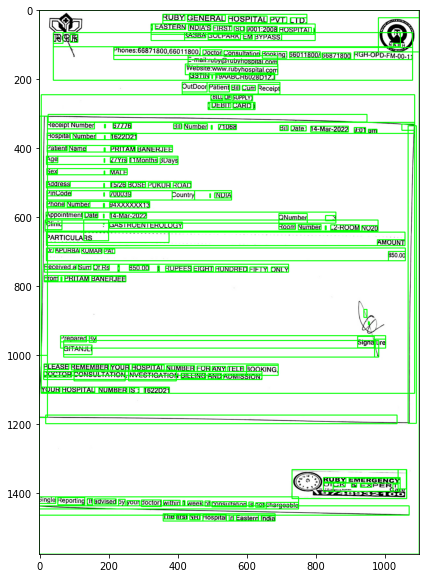

In [6]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_rgb(boxes)

# Step 2: Text recognition

In [7]:
extracted_text = pytesseract.image_to_string(image)
print(extracted_text)

RUBY GENERAL HOSPITAL PVT. LTD.

( EASTERN INDIA'S FIRST ISO 9001:2008 HOSPITAL )
KASBA GOLPARK, EM BYPASS,

Ri I AB
Phones:66871800,66011800, Doctor Consultation Booking: 66011800/ 66871800 RGH-OPD-FM-00-11
E-mail:ruby@rubyhospital.com
Website:www.rubyhospital.com
GSTIN : 19AABCR6028D1ZJ

OutDoor Patient Bill Cum Receipt

(BILL OF SUPPLY)
( DEBIT CARD )
ReceiptNumber : 67776 Bill Number : 71068 Bill Date: 14-Mar-2022 9:01 am |
Hospital Number : 1622D21
Patient Name : PRITAM BANERJEE
Age : 27Yrs 11Months 3Days
Sex : MALE
Address : 15/26 BOSE PUKUR ROAD
PinCode : 700039 Country : INDIA
Phone Number =: 94XXXXXX13
Appointment Date : 14-Mar-2022 QNumber #3
Clinic : GASTROENTEROLOGY Room Number : L2-ROOM NO20
PARTICULARS AMOUNT
Dr. APURBA KUMAR PAL 850.00
Receiveda Sum OfRs ( 850.00 ) RUPEES EIGHT HUNDRED FIFTY ONLY
From : PRITAM BANERJEE.
\
\
Prepared By Signa} lure
GITANJLI \
PLEASE REMEMBER YOUR HOSPITAL NUMBER FOR ANY TELE BOOKING,
DOCTOR CONSULTATION, INVESTIGATION BILLING AND ADMISSIO

# Step 3: Extracting grand total

We will use regular expression to extract all floating point numbers out of the all detected texts.

In [8]:
def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique

In [9]:
amounts = find_amounts(extracted_text)
amounts

[850.0]

Grand total is the largest one:

In [10]:
max(amounts)

850.0

# Step 3: Getting the Text NER

We will use regular expression to extract all floating point numbers out of the all detected texts.

In [45]:
from skimage.filters import threshold_local
import argparse
import torch
import json
from torch import nn
import json
import os
import random
from os import path
from string import ascii_uppercase, digits, punctuation
import math
import colorama
import numpy
import regex

In [48]:
def get_acc(directory, path):
    font     = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    fontColor  = (255,0,0)
    lineType = 1
#     path = directory+path
    # path = args['image']
    # op_path = args['output']

    op_path = directory
    if op_path[-1]!='/':
    	op_path.append('/')


    #Threshold
    image = cv2.imread(path)
    print(path)

    height,width,channel = image.shape

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    T = threshold_local(gray, 15, offset = 6, method = "gaussian") # generic, mean, median, gaussian
    thresh = (gray > T).astype("uint8") * 255
    thresh = ~thresh

    #cv2.imwrite(op_path+'threshold.png', thresh)

    #Dilation
    kernel =np.ones((1,1), np.uint8)
    ero = cv2.erode(thresh, kernel, iterations= 1)
    img_dilation = cv2.dilate(ero, kernel, iterations=1)
    #cv2.imwrite(op_path+'dilated.png', img_dilation)

    # Remove noise
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_dilation, None, None, None, 8, cv2.CV_32S)
    sizes = stats[1:, -1] #get CC_STAT_AREA component
    final = np.zeros((labels.shape), np.uint8)
    for i in range(0, nlabels - 1):
        if sizes[i] >= 10:   #filter small dotted regions
            final[labels == i + 1] = 255
    #cv2.imwrite(op_path+'final.png', final)
    #Find contours
    kern = np.ones((5,15), np.uint8)
    img_dilation = cv2.dilate(final, kern, iterations = 1)
    #cv2.imwrite(op_path+'contours.png', img_dilation)
    contours, hierarchy = cv2.findContours(img_dilation, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Map contours to bounding rectangles, using bounding_rect property
    rects = map(lambda c: cv2.boundingRect(c), contours)
    # Sort rects by top-left x (rect.x == rect.tl.x)
    sorted_rects = sorted(rects, key =lambda r: r[0])
    sorted_rects = sorted(sorted_rects, key =lambda r: r[1])

    tt = image.copy()
    dictionary = {}
    etfo=''
    for i,rect in enumerate(sorted_rects):
        temp_dic = {}
        x,y,w,h = rect
        if(w<20 or h<20):
            continue
        temp_dic['coords'] = [x,y,w,h]
        words = []
        temp = tt[y:y+h, x:x+w]
        #cv2.imwrite('/content/gdrive/My Drive/ResearchPaper/AIESI_complete_pipeline/temp/'+str(i)+'.png',temp)
        temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        hi = pytesseract.image_to_data(temp, config=r'--psm 6')
        hi = hi.split()
        ind = 22
        while(True):
            if (ind>len(hi)):
                break
            if((hi[ind])=='-1'):
                ind+=11
            else:
                #cv2.putText(image,hi[ind]+','+hi[ind+1], (x,y), font, fontScale,fontColor,lineType)
                tem = {}
                tem['confidence'] = hi[ind]
                tem['text'] = hi[ind+1]
                etfo=etfo+hi[ind+1]
                etfo=etfo+" "
                x+=len(hi[ind+1])*20
                ind+=12
                words.append(tem)
        temp_dic['words'] = words
        etfo=etfo+'\n'
        #cvw.rectangle(image, rect, cvw.Color.GREEN, thickness=1)
        dictionary[i] = temp_dic


    cv2.imwrite(op_path+"result.png", image)
    return json.dumps(dictionary),etfo

In [49]:
gson_data, etfo = get_acc('/','S_2.png')
print(gson_data)

S_2.png
{"0": {"coords": [22, 6, 110, 132], "words": [{"confidence": "20.862038", "text": "4"}, {"confidence": "0.000000", "text": "o"}]}, "1": {"coords": [350, 10, 432, 31], "words": [{"confidence": "96.857079", "text": "RUBY"}, {"confidence": "96.308723", "text": "GENERAL"}, {"confidence": "96.308723", "text": "HOSPITAL"}, {"confidence": "96.494240", "text": "PVT."}, {"confidence": "96.069588", "text": "LTD."}]}, "2": {"coords": [209, 24, 885, 122], "words": [{"confidence": "22.649345", "text": "ee"}, {"confidence": "18.657852", "text": "en"}, {"confidence": "35.946968", "text": "Oe"}, {"confidence": "31.085381", "text": "et"}, {"confidence": "17.092224", "text": "RR"}, {"confidence": "16.866089", "text": "A"}, {"confidence": "11.934402", "text": "ASPs"}, {"confidence": "35.454681", "text": "OW"}, {"confidence": "12.733078", "text": "Ae"}, {"confidence": "21.199463", "text": "he"}, {"confidence": "0.000000", "text": ",a~N"}, {"confidence": "81.218842", "text": "(EASTERN"}, {"confiden

In [50]:
class MyModel0(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=2, bidirectional=True)
        self.linear = nn.Linear(hidden_size * 2, 5)

    def forward(self, inpt):
        embedded = self.embed(inpt)
        feature, _ = self.lstm(embedded)
        oupt = self.linear(feature)
        return oupt

In [51]:
device= 'cpu'
hidden_size = 256

device= torch.device('cpu')

In [52]:
VOCAB= ascii_uppercase+digits+punctuation+" \t\n"

In [53]:
print(etfo)

4 o 
RUBY GENERAL HOSPITAL PVT. LTD. 
ee en Oe et RR A ASPs OW Ae he ,a~N (EASTERN INDIA'S FIRST ISO 9001:2008 HOSPITAL ) "| @ \ KASBA GOLPARK, EM BYPASS, “Ly! Phones:66871800,66011800, Doctor Consultation Booking: 66011800/ 66871800 RGH-OPD-FM-00-11 (Sn | ee oe i nee a 
(EASTERN INDIA'S FIRST ISO 9001:2008 HOSPITAL ) SREP date Ce 
KASBA GOLPARK, EM BYPASS, 
E-mail:ruby@rubyhospital.com 
Website:www.rubyhospital.com GSTIN : 19AABCR6028D1ZJ 
GSTIN 
OutDoor Patient Bill Cum Receipt 
(BILL OF SUPPLY) 
( DEBIT CARD ) 
ReceiptNumber : 67776 Bill Number : 71068 Bill Date: 14-Mar-2022 9:01 am Hospital Number : 1622D21 Patient Name : PRITAM BANERJEE Age : 27Yrs 11Months 3Days Sex : MALE Address : 15/26 BOSE PUKUR ROAD PinCode : 700039 Country : INDIA Phone Number =: 94XXXXXX13 Appointment Date : 14-Mar-2022 QNumber #3 Clinic : GASTROENTEROLOGY Room Number : L2-ROOM NO20 PARTICULARS AMOUNT Dr. APURBA KUMAR PAL 850.00 Receiveda SumOfRs ( 850.00 ) RUPEES EIGHT HUNDRED FIFTY ONLY From : PRITAM BAN

In [54]:
temp_text=''
for i in range(664):
    temp_text=temp_text+etfo[i]
etfo=temp_text

In [55]:
# conver lower text to uppper text in ETFO
etfo= etfo.upper()
print(etfo)

4 O 
RUBY GENERAL HOSPITAL PVT. LTD. 
EE EN OE ET RR A ASPS OW AE HE ,A~N (EASTERN INDIA'S FIRST ISO 9001:2008 HOSPITAL ) "| @ \ KASBA GOLPARK, EM BYPASS, “LY! PHONES:66871800,66011800, DOCTOR CONSULTATION BOOKING: 66011800/ 66871800 RGH-OPD-FM-00-11 (SN | EE OE I NEE A 
(EASTERN INDIA'S FIRST ISO 9001:2008 HOSPITAL ) SREP DATE CE 
KASBA GOLPARK, EM BYPASS, 
E-MAIL:RUBY@RUBYHOSPITAL.COM 
WEBSITE:WWW.RUBYHOSPITAL.COM GSTIN : 19AABCR6028D1ZJ 
GSTIN 
OUTDOOR PATIENT BILL CUM RECEIPT 
(BILL OF SUPPLY) 
( DEBIT CARD ) 
RECEIPTNUMBER : 67776 BILL NUMBER : 71068 BILL DATE: 14-MAR-2022 9:01 AM HOSPITAL NUMBER : 1622D21 PATIENT NAME : PRITAM BANERJEE AGE : 27YRS 11


In [56]:
def get_test_data():
    
    text = etfo
    text_tensor = torch.zeros(len(text), 1, dtype=torch.long)
    text_tensor[:, 0] = torch.LongTensor([VOCAB.find(c) for c in text])

    return text_tensor.to(device)

text_tensor = get_test_data()


In [57]:
print(text_tensor.shape)

torch.Size([664, 1])


In [58]:
def pred_to_dict(text, pred, prob):
    res = {"company": ("", 0), "date": ("", 0), "address": ("", 0), "total": ("", 0)}
    keys = list(res.keys())

    seps = [0] + (numpy.nonzero(numpy.diff(pred))[0] + 1).tolist() + [len(pred)]
    for i in range(len(seps) - 1):
        pred_class = pred[seps[i]] - 1
        if pred_class == -1:
            continue

        new_key = keys[pred_class]
        new_prob = prob[seps[i] : seps[i + 1]].max()
        if new_prob > res[new_key][1]:
            res[new_key] = (text[seps[i] : seps[i + 1]], new_prob)

    return {k: regex.sub(r"[\t\n]", " ", v[0].strip()) for k, v in res.items()}


In [59]:
print(text_tensor.shape)
for i in range(len(text_tensor)-1):
  if text_tensor[i]<0 or text_tensor[i]>70:
    text_tensor = torch.cat([text_tensor[0:i], text_tensor[i+1:]])

torch.Size([664, 1])


In [61]:

def test():
    
    model = MyModel0(len(VOCAB), 16, hidden_size).to(device)
    # dataset = MyDataset(None, args.device, test_path="/content/gdrive/My Drive/ResearchPaper/KIPE/data/test_dict.pth")

    model.load_state_dict(torch.load("model.pth"))

    model.eval()
  
    with torch.no_grad():
            oupt = model(text_tensor)
            prob = torch.nn.functional.softmax(oupt, dim=2)
            prob, pred = torch.max(prob, dim=2)
            prob = prob.squeeze().cpu().numpy()
            pred = pred.squeeze().cpu().numpy()
            real_text = etfo
            result = pred_to_dict(real_text, pred, prob)

            with open("result" + 'result' + ".json", "w", encoding="utf-8") as json_opened:
                json.dump(result, json_opened, indent=4)

            print(result)
            #print(key)


if __name__ == "__main__":
    test()

{'company': '( DEBIT CA', 'date': '14-MAR-202', 'address': 'AS', 'total': ''}
